In [71]:
import pandas as pd

# Data cleanup and preparation

Data reading and cleaning steps include:

transaction_data
1. Deduplicate tranasction_data on transaction_id, item_id and transaction_date. Take the first entry
2. Create transaction_date from transaction_date_time
3. If listing_price is null, fill it with most frequent listing_price for the item_id. 
4. If net_revenue is null, fill with zero. 
6. Create a filter for store no betweem S001 and S879.
9. Aggregate transaction_data on item_id, transaction_date. Find the sum of sales_quantity, sum of net_revenue, net_unit_price as net_revenue/sales_quantity. 
10. Fill the aggregated data with zero for missing dates.


In [72]:
def clean_transaction_data(transaction_df):
    # 1. Deduplicate transaction_data on transaction_id, item_id and transaction_date. Take the first entry.
    transaction_df = transaction_df.drop_duplicates(subset=['transaction_id', 'item_id', 'transaction_date_time'], keep='first')
    
    # 2. Create transaction_date from transaction_date_time
    transaction_df['transaction_date'] = transaction_df['transaction_date_time'].dt.date
    
    # 3. If listing_price is null, fill it with the most frequent listing_price for the item_id.
    transaction_df['listing_price'] = transaction_df.groupby('item_id')['listing_price'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean())
    )
    
    # 4. If net_revenue is null, fill with zero.
    transaction_df['net_revenue'] = transaction_df['net_revenue'].fillna(0)
        
    # 6. Create a filter for store no between S001 and S879.
    store_filter = transaction_df['store'].apply(lambda x: 'S001' <= x <= 'S879')
    transaction_df = transaction_df[store_filter]
        
    return transaction_df


def aggregate_transaction_data(transaction_df):
    # 9. Aggregate transaction_data on item_id, transaction_date.
    agg_df = transaction_df.groupby(['item_id', 'transaction_date']).agg(
        sales_quantity_sum=('sales_quantity', 'sum'),
        net_revenue_sum=('net_revenue', 'sum'),
        listing_price_mean=('listing_price', 'mean')
    ).reset_index()
    
    # Calculate net_unit_price as net_revenue_sum / sales_quantity_sum
    agg_df['net_unit_price'] = agg_df['net_revenue_sum'] / agg_df['sales_quantity_sum']
    
    return agg_df


# Filling missing dates with zero sales quantity
def fill_missing_dates(aggregated_df, end_date):
    # Get the first transaction date for each item
    first_transaction_dates = aggregated_df.groupby('item_id')['transaction_date'].min().reset_index()
    
    filled_aggregated_df = pd.DataFrame()

    for _, row in first_transaction_dates.iterrows():
        item_id = row['item_id']
        start_date = row['transaction_date']
        
        item_dates = pd.date_range(start=start_date, end=end_date)
        item_full_index = pd.MultiIndex.from_product([[item_id], item_dates], names=['item_id', 'transaction_date'])
        
        item_aggregated_df = aggregated_df[aggregated_df['item_id'] == item_id].set_index(['item_id', 'transaction_date'])
        
        # Reindex to include all dates
        item_aggregated_df = item_aggregated_df.reindex(item_full_index, fill_value=0).reset_index()
        
        # Fill in net_unit_price for the missing dates with NaN since it's undefined
        item_aggregated_df['net_unit_price'] = item_aggregated_df.apply(
            lambda row: row['net_revenue_sum'] / row['sales_quantity_sum'] if row['sales_quantity_sum'] > 0 else 0, axis=1
        )
        
        filled_aggregated_df = pd.concat([filled_aggregated_df, item_aggregated_df])

    return filled_aggregated_df.reset_index(drop=True)


transaction_df =  pd.read_csv("../data/transaction_data.csv")
transaction_df['transaction_date_time'] = pd.to_datetime(transaction_df['transaction_date_time'])

# Cleaning the data
cleaned_transaction_df = clean_transaction_data(transaction_df)

# Aggregating the data
aggregated_transaction_df = aggregate_transaction_data(cleaned_transaction_df)


# Save the cleaned and aggregated data to CSV files
cleaned_transaction_df.to_csv('../data/cleaned_transaction_data.csv', index=False)
end_date = cleaned_transaction_df['transaction_date'].max()
filled_aggregated_transaction_df = fill_missing_dates(aggregated_transaction_df, end_date)
filled_aggregated_transaction_df.to_csv('../data/filled_aggregated_transaction_df.csv', index=False)


print("Data cleaning and aggregation completed. Files saved.")

Data cleaning and aggregation completed. Files saved.


In [73]:
# read promotional data and add a flag for the dates on which there was promotion to aggregated data
promo_df = pd.read_csv("../data/promotional_dates.csv")
for index, row in promo_df.iterrows():
    mask = (filled_aggregated_transaction_df['transaction_date'] >= row['promo_start_date']) & (filled_aggregated_transaction_df['transaction_date'] <= row['promo_end_date'])
    filled_aggregated_transaction_df.loc[mask, 'promo_flag'] = True
filled_aggregated_transaction_df['promo_flag'] = filled_aggregated_transaction_df['promo_flag'].fillna(False)

/var/folders/l_/794s0n_d5p966xjfmvjx8tgh0000gp/T/ipykernel_81416/2632594912.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filled_aggregated_transaction_df['promo_flag'] = filled_aggregated_transaction_df['promo_flag'].fillna(False)


In [74]:
# Read holdiday table and add a flag if there is holoday on that date.
holiday_df = pd.read_csv("../data/holiday_calendar.csv")
filled_aggregated_transaction_df['transaction_date'] = pd.to_datetime(filled_aggregated_transaction_df['transaction_date'])
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])
filled_aggregated_transaction_df['holiday_flag'] = False
filled_aggregated_transaction_df.loc[filled_aggregated_transaction_df['transaction_date'].isin(holiday_df['ds']),'holiday_flag'] = True

In [75]:
# add a flag for weekend 
filled_aggregated_transaction_df['weekend_flag'] = filled_aggregated_transaction_df['transaction_date'].dt.dayofweek >= 5


In [76]:
# for each item_id, add a flag for holiday ahead and promo ahead
filled_aggregated_transaction_df = filled_aggregated_transaction_df.sort_values(['item_id','transaction_date'])
filled_aggregated_transaction_df['holiday_ahead'] = filled_aggregated_transaction_df.groupby('item_id')['holiday_flag'].shift(-1).fillna(False)
filled_aggregated_transaction_df['promo_ahead'] = filled_aggregated_transaction_df.groupby('item_id')['promo_flag'].shift(-1).fillna(False)

/var/folders/l_/794s0n_d5p966xjfmvjx8tgh0000gp/T/ipykernel_81416/1543513973.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filled_aggregated_transaction_df['holiday_ahead'] = filled_aggregated_transaction_df.groupby('item_id')['holiday_flag'].shift(-1).fillna(False)
/var/folders/l_/794s0n_d5p966xjfmvjx8tgh0000gp/T/ipykernel_81416/1543513973.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filled_aggregated_transaction_df['promo_ahead'] = filled_aggregated_transaction_df.groupby('item_id')['promo_flag'].shift(-1).fillna(False)


In [77]:
# read item_metadata and add the item metadata to the aggregated data
item_metadata = pd.read_csv("../data/article_metadata.csv")
final_df = pd.merge(filled_aggregated_transaction_df, item_metadata, on='item_id',how='left')
final_df.to_csv('../data/final_aggregated_data.csv', index=False)

# known covariate creation

In [96]:
kc_base =  pd.read_parquet('../data/known_covariates_base.parquet')
kc_base['transaction_date'] = kc_base['transaction_date_time'].dt.date
kc_base = kc_base.drop(columns=['transaction_date_time'])
kc_base['transaction_date'] = pd.to_datetime(kc_base['transaction_date'])

In [97]:
kc_base['transaction_date'] = pd.to_datetime(kc_base['transaction_date'])
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])
kc_base['holiday_flag'] = False
kc_base.loc[kc_base['transaction_date'].isin(holiday_df['ds']),'holiday_flag'] = True

In [100]:
for index, row in promo_df.iterrows():
    mask = (kc_base['transaction_date'] >= row['promo_start_date']) & (kc_base['transaction_date'] <= row['promo_end_date'])
    kc_base.loc[mask, 'promo_flag'] = True
kc_base['promo_flag'] = kc_base['promo_flag'].fillna(False)

/var/folders/l_/794s0n_d5p966xjfmvjx8tgh0000gp/T/ipykernel_81416/1331088055.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  kc_base['promo_flag'] = kc_base['promo_flag'].fillna(False)


In [101]:
# add a flag for weekend 
kc_base['weekend_flag'] = kc_base['transaction_date'].dt.dayofweek >= 5


In [102]:
kc_base = kc_base.sort_values(['item_id','transaction_date'])
kc_base['holiday_ahead'] = kc_base.groupby('item_id')['holiday_flag'].shift(-1).fillna(False)
kc_base['promo_ahead'] = kc_base.groupby('item_id')['promo_flag'].shift(-1).fillna(False)

/var/folders/l_/794s0n_d5p966xjfmvjx8tgh0000gp/T/ipykernel_81416/994108839.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  kc_base['holiday_ahead'] = kc_base.groupby('item_id')['holiday_flag'].shift(-1).fillna(False)
/var/folders/l_/794s0n_d5p966xjfmvjx8tgh0000gp/T/ipykernel_81416/994108839.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  kc_base['promo_ahead'] = kc_base.groupby('item_id')['promo_flag'].shift(-1).fillna(False)


In [104]:
kc_base.to_parquet('../data/known_covariates_final.parquet', index=False)

# Data visualisation

In [78]:
final_df

,item_id,transaction_date,sales_quantity_sum,net_revenue_sum,listing_price_mean,net_unit_price,promo_flag,holiday_flag,weekend_flag,holiday_ahead,promo_ahead,item_height,item_width,item_length,item_weight,article_category
0,ITEM0001,2020-01-01,640.0,35200.00,55.000000,55.000000,True,True,False,False,True,29.53,82.49,89.19,4.01,Electronics
1,ITEM0001,2020-01-02,838.0,46090.00,55.000000,55.000000,True,False,False,False,True,29.53,82.49,89.19,4.01,Electronics
2,ITEM0001,2020-01-03,956.0,52580.00,55.000000,55.000000,True,False,False,False,True,29.53,82.49,89.19,4.01,Electronics
3,ITEM0001,2020-01-04,1467.0,80685.00,55.000000,55.000000,True,False,True,False,True,29.53,82.49,89.19,4.01,Electronics
4,ITEM0001,2020-01-05,1372.0,75456.47,55.007605,54.997427,True,False,True,False,True,29.53,82.49,89.19,4.01,Electronics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122842,ITEM0100,2024-01-27,42.0,56700.00,1350.000000,1350.000000,True,False,True,False,False,92.30,16.26,81.72,17.57,Electronics
122843,ITEM0100,2024-01-28,55.0,74250.00,1350.000000,1350.000000,False,False,True,False,False,92.30,16.26,81.72,17.57,Electronics
122844,ITEM0100,2024-01-29,46.0,62100.00,1350.000000,1350.000000,False,False,False,False,False,92.30,16.26,81.72,17.57,Electronics
122845,ITEM0100,2024-01-30,32.0,43200.00,1350.000000,1350.000000,False,False,False,False,False,92.30,16.26,81.72,17.57,Electronics


Text(0.5, 0, 'Day of week')

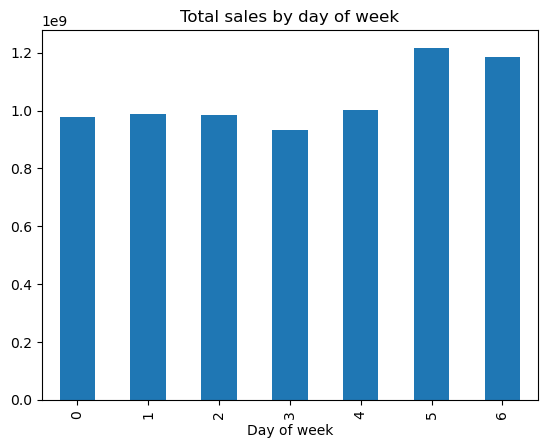

In [79]:
# plot the total sales(net_revenue_sum) for different day of week
import matplotlib.pyplot as plt
import seaborn as sns
final_df['day_of_week'] = final_df['transaction_date'].dt.dayofweek
day_of_week_sales = final_df.groupby('day_of_week')['net_revenue_sum'].sum()
day_of_week_sales.plot(kind='bar')
plt.title('Total sales by day of week')
plt.xlabel('Day of week')

The total sales increases on weekends by 20%

Text(0.5, 0, 'Day of month')

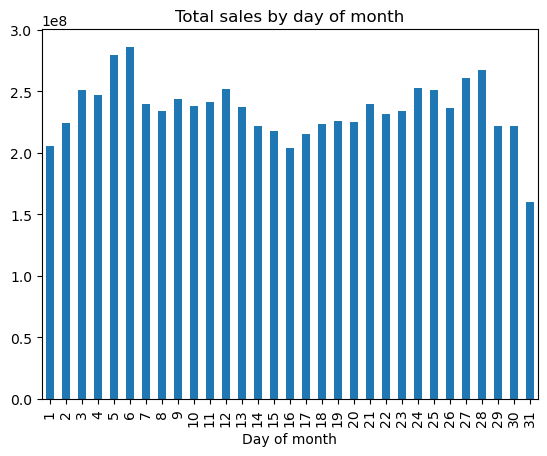

In [80]:
# plot the total sales(net_revenue_sum) for different day of month
final_df['day_of_month'] = final_df['transaction_date'].dt.day
day_of_month_sales = final_df.groupby('day_of_month')['net_revenue_sum'].sum()
day_of_month_sales.plot(kind='bar')
plt.title('Total sales by day of month')
plt.xlabel('Day of month')

Sales is highest in the first week of the month and lowest in the third week of the month

Text(0.5, 0, 'Month')

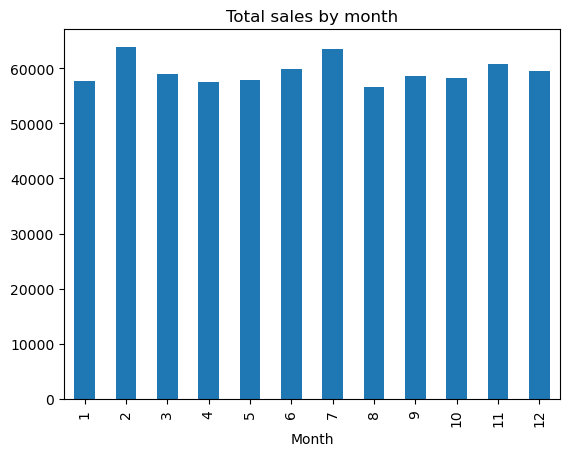

In [81]:
# plot the total sales(net_revenue_sum) for different month
final_df['month'] = final_df['transaction_date'].dt.month
month_sales = final_df.groupby('month')['net_revenue_sum'].mean()
month_sales.plot(kind='bar')
plt.title('Total sales by month')
plt.xlabel('Month')


Sales is highest in June and July and lowest in August

Text(0.5, 1.0, 'Total sales by holiday')

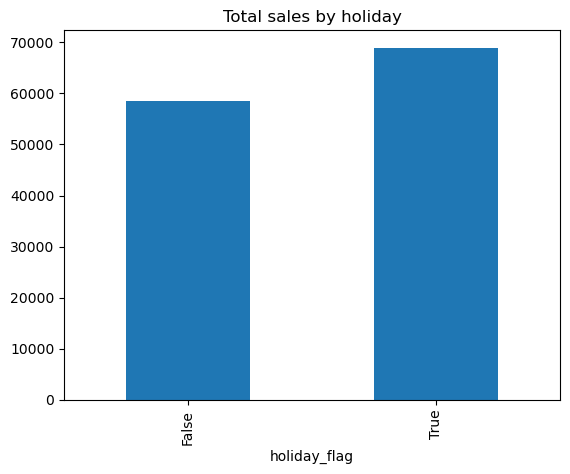

In [86]:
# plot the total sales(net_revenue_sum) for holiday and non-holiday
holiday_sales = final_df.groupby('holiday_flag')['net_revenue_sum'].mean()
holiday_sales.plot(kind='bar')
plt.title('Total sales by holiday')

sales increases on holidays by 17%

In [92]:
final_df

,item_id,transaction_date,sales_quantity_sum,net_revenue_sum,listing_price_mean,net_unit_price,promo_flag,holiday_flag,weekend_flag,holiday_ahead,promo_ahead,item_height,item_width,item_length,item_weight,article_category,day_of_week,day_of_month,month
0,ITEM0001,2020-01-01,640.0,35200.00,55.000000,55.000000,True,True,False,False,True,29.53,82.49,89.19,4.01,Electronics,2,1,1
1,ITEM0001,2020-01-02,838.0,46090.00,55.000000,55.000000,True,False,False,False,True,29.53,82.49,89.19,4.01,Electronics,3,2,1
2,ITEM0001,2020-01-03,956.0,52580.00,55.000000,55.000000,True,False,False,False,True,29.53,82.49,89.19,4.01,Electronics,4,3,1
3,ITEM0001,2020-01-04,1467.0,80685.00,55.000000,55.000000,True,False,True,False,True,29.53,82.49,89.19,4.01,Electronics,5,4,1
4,ITEM0001,2020-01-05,1372.0,75456.47,55.007605,54.997427,True,False,True,False,True,29.53,82.49,89.19,4.01,Electronics,6,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122842,ITEM0100,2024-01-27,42.0,56700.00,1350.000000,1350.000000,True,False,True,False,False,92.30,16.26,81.72,17.57,Electronics,5,27,1
122843,ITEM0100,2024-01-28,55.0,74250.00,1350.000000,1350.000000,False,False,True,False,False,92.30,16.26,81.72,17.57,Electronics,6,28,1
122844,ITEM0100,2024-01-29,46.0,62100.00,1350.000000,1350.000000,False,False,False,False,False,92.30,16.26,81.72,17.57,Electronics,0,29,1
122845,ITEM0100,2024-01-30,32.0,43200.00,1350.000000,1350.000000,False,False,False,False,False,92.30,16.26,81.72,17.57,Electronics,1,30,1
